# Time-Series Forecasting w/ Additional Regressors

In this exercise, we will explore the powerful capabilities of the Facebook Prophet library. This library hosts a generalized linear model. These models excel at regression tasks and are also capable of incorporating additional variables, yielding added efficiency and scope to the outputs.

![Image]("/content/regressionimage.jpg")

In [22]:
# Insatall packages
!pip install kaggle prophet

In [46]:
# Import libraries
import os
from google.colab import userdata
key = userdata.get('kaggle_key')
import zipfile
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import random
import time
import logging
from multiprocessing import Pool, cpu_count
# Export credentials
os.environ["KAGGLE_USERNAME"] = "deeguy"
os.environ["KAGGLE_KEY"] = key

In [32]:
# Create a function to perform modeling
def prophet_model(item):

    # Init model
    model = Prophet(holidays = holidays[['ds', 'holiday']])
    model.add_regressor('onpromotion') #, standardize = False)
    model.add_regressor('oil' )#, standardize = False)

    # Compile data
    trainingdata = df[['ds', item]].rename({item: 'y'}, axis = 1)
    trainingdata['y'] = trainingdata['y'].astype(float)

    # Add regressors
    trainingdata = trainingdata.merge(promos[['ds', item]], how = 'left').rename({item: 'onpromotion'}, axis = 1).merge(oil, how = 'left', on = 'ds')
    trainingdata['onpromotion'] = trainingdata['onpromotion'].fillna(0)
    trainingdata['oil'] = trainingdata['oil'].fillna(method = 'bfill')

    # Train
    model.fit(trainingdata)

    # Init predictions
    fut = model.make_future_dataframe(periods = 16)
    merge_content = test_promos[['ds', item]].rename({item: 'onpromotion'}, axis = 1).merge(oil, how = 'left', on = 'ds')
    fut = fut.merge(merge_content)
    fut['oil'] = fut['oil'].fillna(method = 'bfill')

    # Model
    preds = model.predict(fut)[['ds', 'yhat']]
    preds['ds'] = pd.to_datetime(preds['ds'])

    # Output
    out = test[test['item'] == item].drop('item', axis = 1)

    return out.merge(preds, how = 'left', on = 'ds').rename({'yhat': 'sales'}, axis = 1)

In [3]:
!kaggle competitions download -c store-sales-time-series-forecasting

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 1.06GB/s]


In [6]:
with zipfile.ZipFile('/content/store-sales-time-series-forecasting.zip', 'r') as zip_ref:

    zip_ref.extractall()

In [11]:
!cd /content

In [12]:
!ls

holidays_events.csv  sample_submission.csv		      test.csv
oil.csv		     store-sales-time-series-forecasting.zip  train.csv
sample_data	     stores.csv				      transactions.csv


In [14]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
holidays = pd.read_csv('holidays_events.csv').rename({'date': 'ds', 'description': 'holiday'}, axis = 1)
oil = pd.read_csv('oil.csv').rename({'date': 'ds', 'dcoilwtico': 'oil'}, axis = 1).fillna(method = 'bfill')

/tmp/ipython-input-14-3335042048.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil = pd.read_csv('oil.csv').rename({'date': 'ds', 'dcoilwtico': 'oil'}, axis = 1).fillna(method = 'bfill')


In [15]:
# Inspect data
print(f"Unique Item Families:    {train['family'].nunique()}")
print(f"# Stores:                {train['store_nbr'].nunique()}")
print(f"Dataset start date:      {min(train['date'])}")
print(f"Dataset end date:        {max(train['date'])}")
print(f"Test set start date:     {min(test['date'])}")
print(f"Test set end date:       {max(test['date'])}")

interval = pd.date_range(min(train['date']), max(train['date']), freq = 'd')

print(f"Num Days:               {len(interval)}")
print(f"Train Shape:            {train['date'].nunique()}")

Unique Item Families:    33
# Stores:                54
Dataset start date:      2013-01-01
Dataset end date:        2017-08-15
Test set start date:     2017-08-16
Test set end date:       2017-08-31
Num Days:               1688
Train Shape:            1684


In [16]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [17]:
# Fix dates
train['ds'] = pd.to_datetime(train['date'])
test['ds'] = pd.to_datetime(test['date'])
oil['ds'] = pd.to_datetime(oil['ds'])

# Create a master label for training
train['item'] = train['store_nbr'].astype(str) + '_' + train['family']
test['item'] = test['store_nbr'].astype(str) + '_' + test['family']

# Merge data
test1 = test.merge(oil, how = 'left', on = 'ds').drop('date', axis = 1)
train1 = train.merge(oil, how = 'left', on = 'ds').drop('date', axis = 1)

In [18]:
# Create an index for each product
df = train1.pivot(index = 'ds', columns = 'item', values = 'sales').reset_index() #.rename({'date': 'ds'}, axis = 1)
promos = train1.pivot(index = 'ds', columns = 'item', values = 'onpromotion').reset_index() #.rename({'date': 'ds'}, axis = 1)
test_promos = test1.pivot(index = 'ds', columns = 'item', values = 'onpromotion').reset_index() #.rename({'date': 'ds'}, axis = 1)

# Get an index of all products
items = df.drop('ds', axis = 1).columns

In [24]:
# Init modeling
model = Prophet(holidays = holidays[['ds', 'holiday']])
model.add_regressor('onpromotion') #, standardize = False)
model.add_regressor('oil' )#, standardize = False)

# Compile data
trainingdata = df[['ds', items[0]]].rename({items[0]: 'y'}, axis = 1)
trainingdata['y'] = trainingdata['y'].astype(float)

# cONVERT DATES
trainingdata['ds'] = pd.to_datetime(trainingdata['ds'])
promos['ds'] = pd.to_datetime(promos['ds'])

# Add regressors
trainingdata = trainingdata.merge(promos[['ds', items[0]]]).rename({items[0]: 'onpromotion'}, axis = 1).merge(oil, how = 'left', on = 'ds')

trainingdata['oil'] = trainingdata['oil'].fillna(method = 'bfill')

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
/tmp/ipython-input-24-4021232335.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trainingdata['oil'] = trainingdata['oil'].fillna(method = 'bfill')


In [25]:
trainingdata.head()

,ds,y,onpromotion,oil
0,2013-01-01,0.0,0,93.14
1,2013-01-02,3.0,0,93.14
2,2013-01-03,2.0,0,92.97
3,2013-01-04,2.0,0,93.12
4,2013-01-05,0.0,0,93.20


In [26]:
model.fit(trainingdata)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8cefs3dc/ypvz_chi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8cefs3dc/f5uuql77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19675', 'data', 'file=/tmp/tmp8cefs3dc/ypvz_chi.json', 'init=/tmp/tmp8cefs3dc/f5uuql77.json', 'output', 'file=/tmp/tmp8cefs3dc/prophet_modelorlfxsl0/prophet_model-20250727215930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
# Compile dataset for predictions
fut = model.make_future_dataframe(periods = 16)
merge_content = test_promos[['ds', items[0]]].rename({items[0]: 'onpromotion'}, axis = 1).merge(oil, how = 'left', on = 'ds')
fut = fut.merge(merge_content)
fut['oil'] = fut['oil'].fillna(method = 'bfill')

/tmp/ipython-input-27-2926238784.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fut['oil'] = fut['oil'].fillna(method = 'bfill')


In [28]:
# Run the predictions
fut['ds'] = pd.to_datetime(fut['ds'])
preds = model.predict(fut)

In [29]:
preds[['ds', 'onpromotion', 'oil', 'yhat']].head()

,ds,onpromotion,oil,yhat
0,2017-08-16,0.0,-0.094745,1.743679
1,2017-08-17,0.0,-0.093530,1.506404
2,2017-08-18,0.0,-0.086693,1.770182
3,2017-08-19,0.0,-0.092091,2.863516
4,2017-08-20,0.0,-0.092091,3.262006


In [30]:
# Compile the result
out = test[test['item'] == items[0]].drop('item', axis = 1)
out['ds'] = pd.to_datetime(out['ds'])
out.head()

,id,date,store_nbr,family,onpromotion,ds
33,3000921,2017-08-16,10,AUTOMOTIVE,0,2017-08-16
1815,3002703,2017-08-17,10,AUTOMOTIVE,0,2017-08-17
3597,3004485,2017-08-18,10,AUTOMOTIVE,0,2017-08-18
5379,3006267,2017-08-19,10,AUTOMOTIVE,0,2017-08-19
7161,3008049,2017-08-20,10,AUTOMOTIVE,0,2017-08-20


In [31]:
# cONVERT DATES
df['ds'] = pd.to_datetime(df['ds'])
promos['ds'] = pd.to_datetime(promos['ds'])
test['ds'] = pd.to_datetime(test['ds'])

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
/tmp/ipython-input-38-425752115.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trainingdata['oil'] = trainingdata['oil'].fillna(method = 'bfill')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8cefs3dc/2qgol7bv.json


1782 items contained in the dataset..'
Running model on 13_MAGAZINES


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8cefs3dc/sdxzho_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9009', 'data', 'file=/tmp/tmp8cefs3dc/2qgol7bv.json', 'init=/tmp/tmp8cefs3dc/sdxzho_m.json', 'output', 'file=/tmp/tmp8cefs3dc/prophet_model75iere5l/prophet_model-20250727222221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/tmp/ipython-input-38-425752115.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fut['oil'] = fut['oil'].fillna(method = 'bfill')


Examining Outputs- 


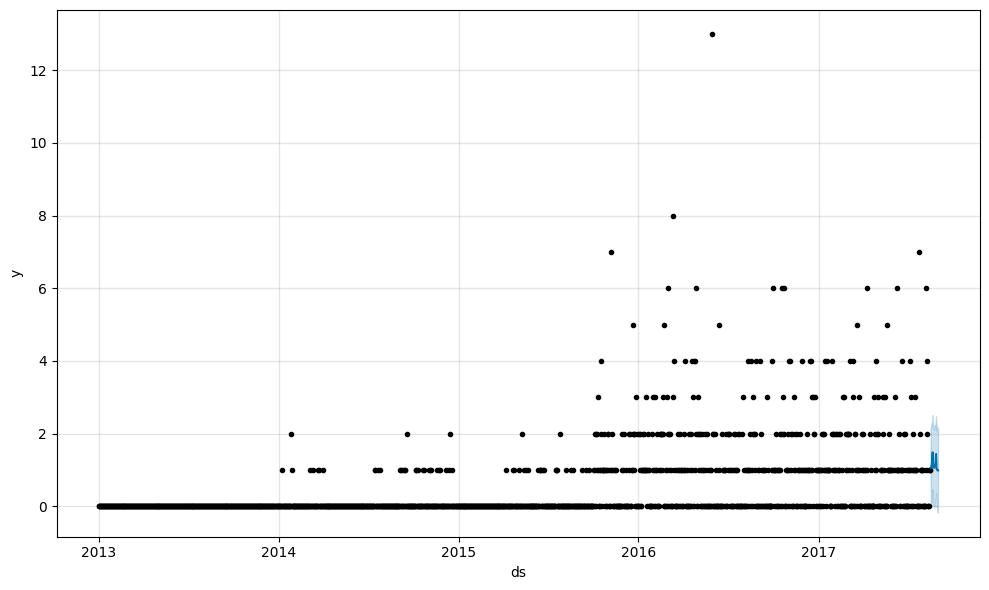

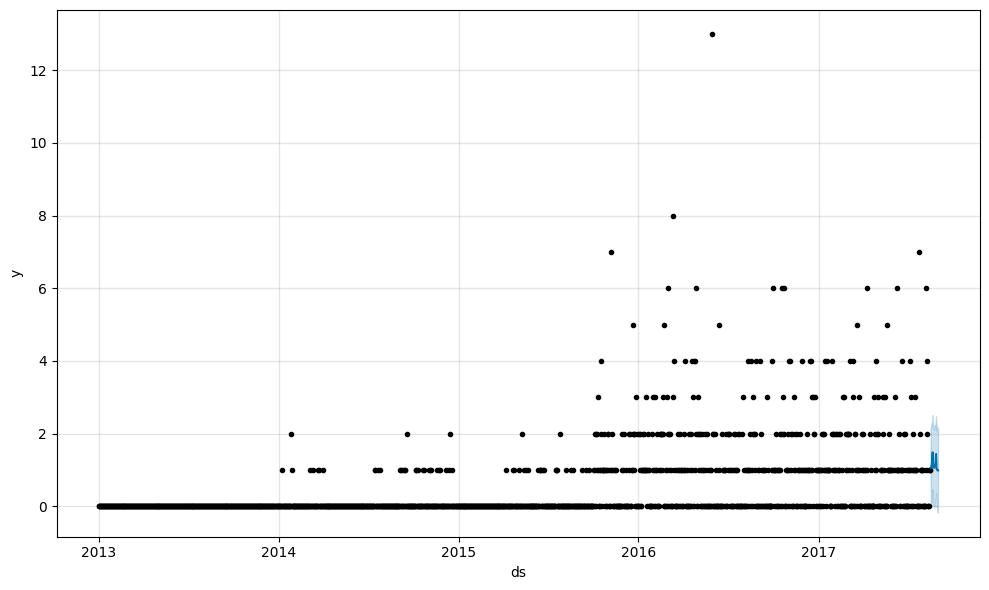

In [38]:
print(f"{len(items)} items contained in the dataset..'")

# Pick a sample
sample = random.choice(items)

print(f"Running model on {sample}")

# Init model
model = Prophet(holidays = holidays[['ds', 'holiday']])
model.add_regressor('onpromotion') #, standardize = False)
model.add_regressor('oil' )#, standardize = False)

# Compile data
trainingdata = df[['ds', sample]].rename({sample: 'y'}, axis = 1)
trainingdata['y'] = trainingdata['y'].astype(float)

# Add regressors
trainingdata = trainingdata.merge(promos[['ds', sample]], how = 'left').rename({sample: 'onpromotion'}, axis = 1).merge(oil, how = 'left', on = 'ds')
trainingdata['onpromotion'] = trainingdata['onpromotion'].fillna(0)
trainingdata['oil'] = trainingdata['oil'].fillna(method = 'bfill')

# Train
model.fit(trainingdata)

# Init predictions
fut = model.make_future_dataframe(periods = 16)
merge_content = test_promos[['ds', sample]].rename({sample: 'onpromotion'}, axis = 1).merge(oil, how = 'left', on = 'ds')
fut = fut.merge(merge_content)
fut['oil'] = fut['oil'].fillna(method = 'bfill')

# Model
preds = model.predict(fut) #[['ds', 'yhat']]
preds['ds'] = pd.to_datetime(preds['ds'])

# Output
out = test[test['item'] == sample].drop('item', axis = 1)
out = out.merge(preds, how = 'left', on = 'ds').rename({'yhat': 'sales'}, axis = 1) #.drop(['ds', 'oil', 'onpromotion'], axis = 1)

print(f"Examining Outputs- ")

model.plot(preds)

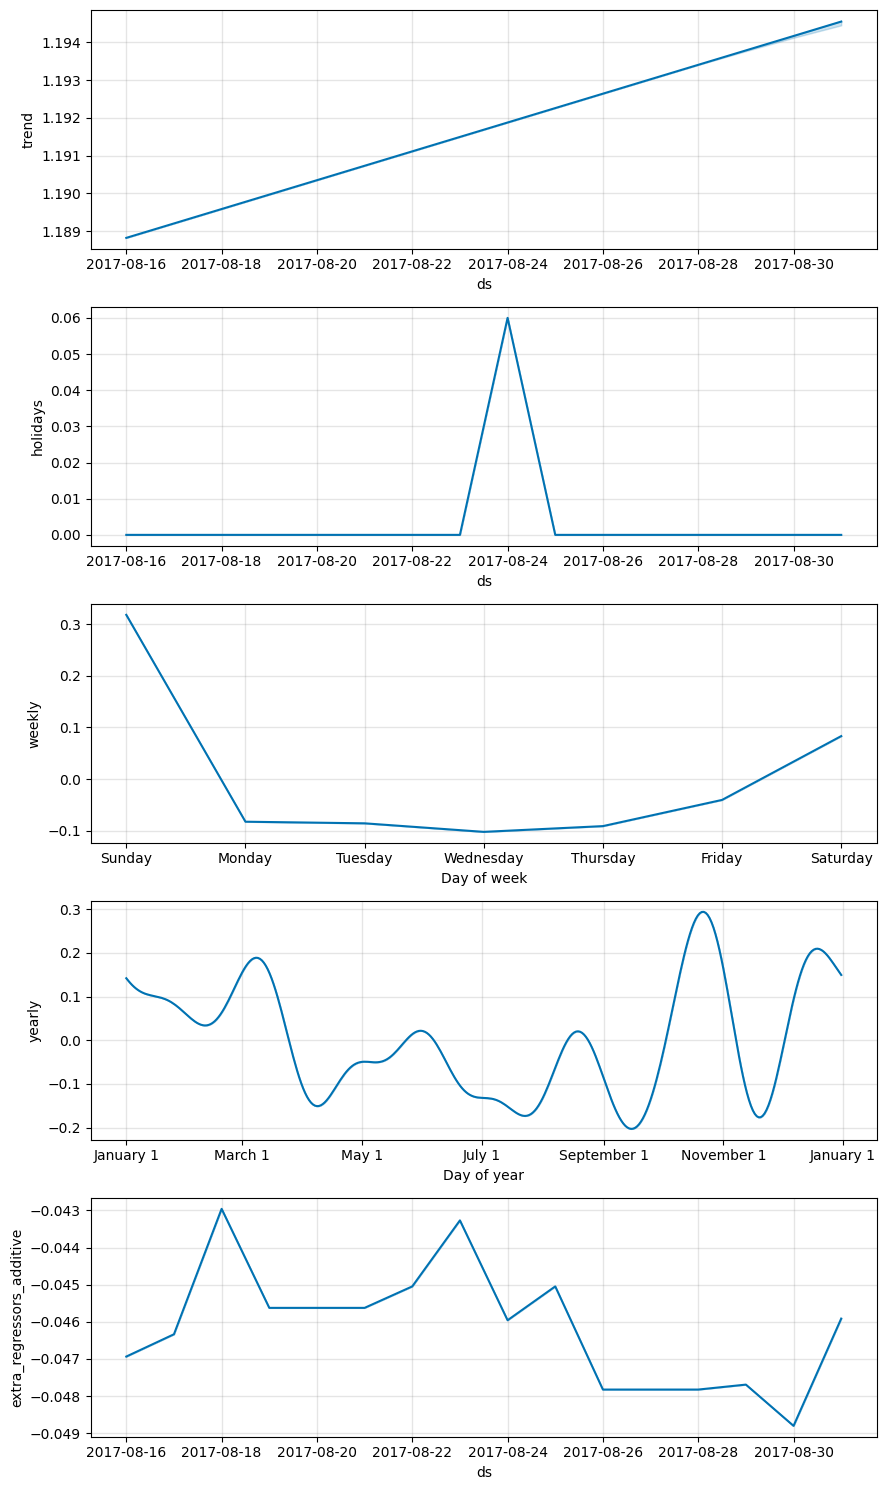

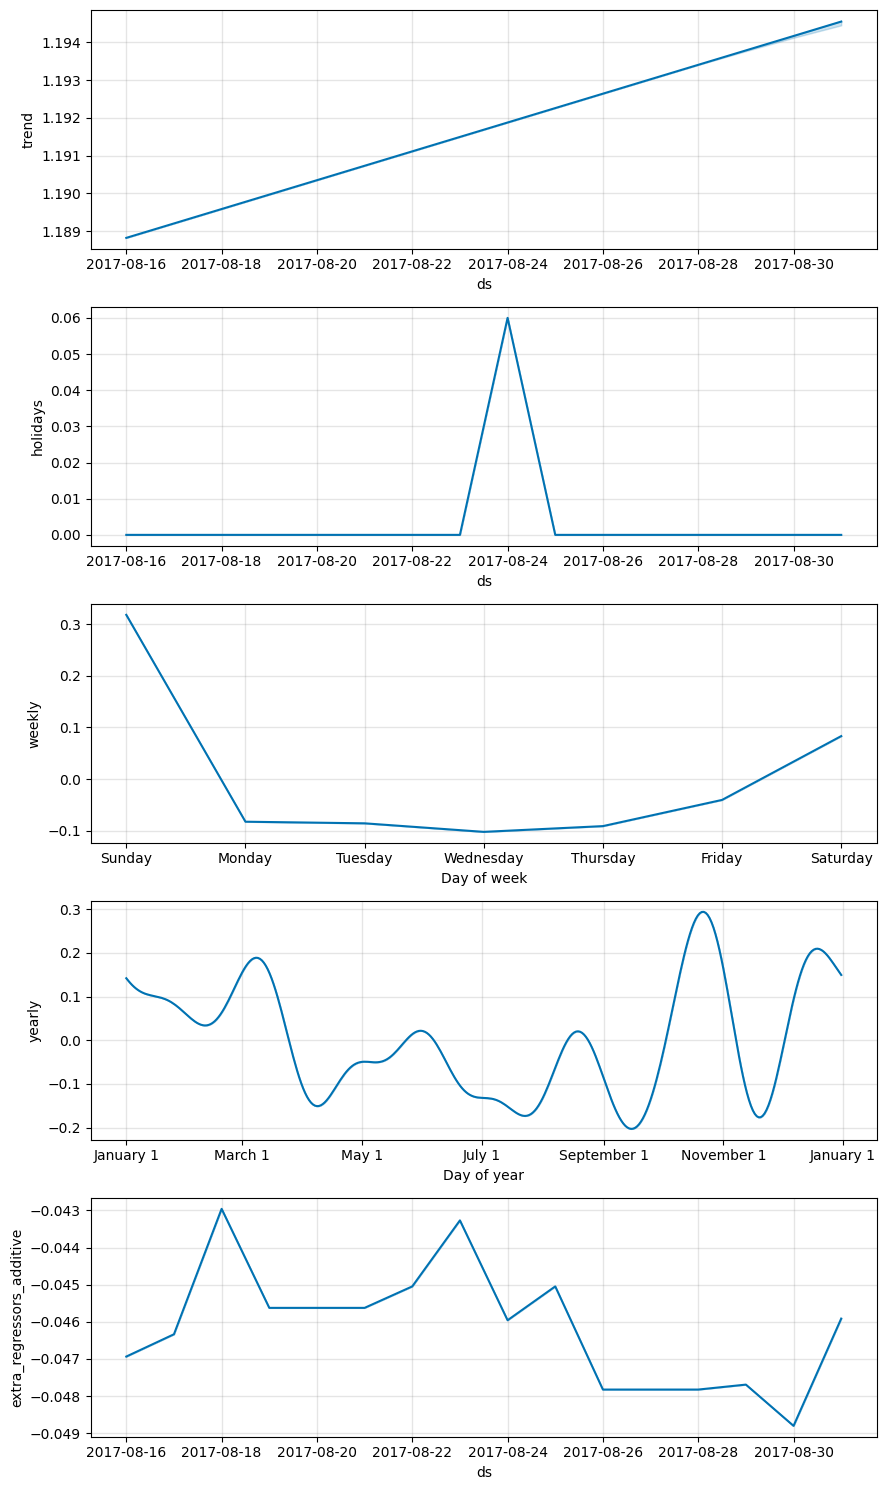

In [39]:
model.plot_components(preds)

In [49]:
%%capture

# Forecast
start = time.time()

# Disable outputs
logging.getLogger("cmdstanpy").disabled = True

# Parallelization
num_cpus = cpu_count() - 1
p = Pool(num_cpus)
result = p.map(prophet_model, items)

end = time.time()

# Compile output
res = pd.concat([i for i in result])
out = res[['id', 'sales']]

# Write file
out.to_csv('submission.csv', index = False)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
print(f'Elapsed Modeling Time:  {round((start - end) / 60, 2)} minutes..')

Elapsed Modeling Time:  -55.4 minutes..


In [51]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "my time-series forecasting attempt!"

100% 727k/727k [00:00<00:00, 2.01MB/s]
Successfully submitted to Store Sales - Time Series Forecasting